In [13]:
import os
import sys
sys.path.append("../NeuralTSNE/")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import NeuralTSNE as ntsne

from torch.utils.data import TensorDataset, random_split
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning import Trainer

%matplotlib inline

The dataset is alanine dipeptide in vaccum, available to download from https://zenodo.org/records/4756093 (`Data-ala1/ala1-vaccum-pt/Ala1-PT.repl0/colvar.0.data`. Features are 45 pairwise distances between heavy atoms. 

Detailed information about the dataset is described in *Multiscale Reweighted Stochastic Embedding (MRSE): Deep Learning of Collective Variables for Enhanced Sampling* (https://doi.org/10.1021/acs.jpca.1c02869).

In [53]:
data = np.loadtxt('data/adp-feat-dist.data')

Use only the distances for learning. 

In [54]:
X = data[:, 5:]

In [55]:
X.shape

(100001, 45)

Prepare the training and validation data.

In [56]:
X = torch.tensor(X, dtype=torch.float32)
dataset = TensorDataset(X)

valid = 0.2
n = len(dataset)
n_train = int((1.0 - valid) * n)
n_valid = n - n_train
train_dataset, valid_dataset = random_split(dataset, [n_train, n_valid])

Initialize a neural network to perform dimensionality reduction.

In [57]:
multipliers = [0.75, 0.75, 0.75]
model = ntsne.TSNE.NeuralNetwork.NeuralNetwork(initial_features=45, n_components=2, multipliers=multipliers)

Initialize parameters for tSNE.

In [58]:
param_tsne = ntsne.TSNE.ParametricTSNE.ParametricTSNE(
    loss_fn="kl_divergence",
    n_components=2,
    perplexity=30,
    batch_size=1000,
    early_exaggeration_epochs=0,
    early_exaggeration_value=0,
    max_iterations=100,
    features=45,
    multipliers=multipliers,
)

Declare a trainer.

In [59]:
early_stopping = EarlyStopping(monitor="val_loss", min_delta=1e-5, patience=10)
trainer = Trainer(
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    log_every_n_steps=50,
    max_epochs=param_tsne.max_iterations,
    callbacks=[early_stopping],
    default_root_dir=".",
)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/jr/miniconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [60]:
reducer = ntsne.TSNE.Modules.DimensionalityReduction(param_tsne, False, lr=1e-3)

Prepare dataloaders with the training and validation data.

In [61]:
train_d, _ = param_tsne.create_dataloaders(train_dataset, None)
valid_d, _ = param_tsne.create_dataloaders(valid_dataset, None)

all_d, _ = param_tsne.create_dataloaders(dataset, None)

Train the trainer, or load a model if it is available.

In [62]:
torch.set_float32_matmul_precision("high")

model_name = "data/adp-model-dist.pt"
if os.path.exists(model_name):
    param_tsne.read_model(model_name)
else:
    trainer.fit(reducer, train_dataloaders=train_d, val_dataloaders=[valid_d])
    param_tsne.save_model(model_name)

Evaluate the model on all available samples from the dataset.

In [69]:
Z = trainer.predict(reducer, all_d)
Z = np.concatenate(Z, axis=0)

Predicting: |                                                                                                 …

In [70]:
np.savetxt("data/adp-colvar-dist.data", Z)

Plot the results.

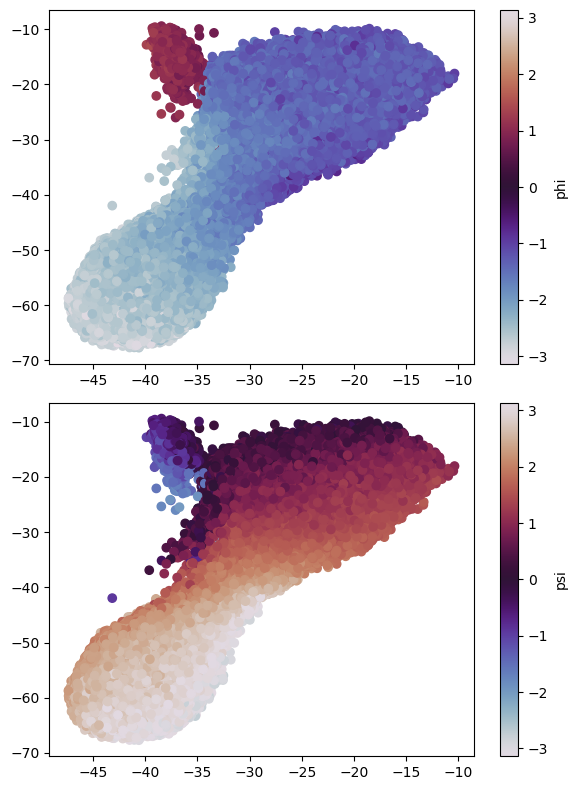

In [85]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8))

sctr = ax[0].scatter(Z[:,0], Z[:, 1], c=data[:, 2], cmap=plt.cm.twilight)
plt.colorbar(sctr, ax=ax[0], label='phi')

sctr = ax[1].scatter(Z[:,0], Z[:, 1], c=data[:, 3], cmap=plt.cm.twilight)
plt.colorbar(sctr, ax=ax[1], label='psi')

plt.tight_layout()